<a href="https://colab.research.google.com/github/benai9916/Deep-Learning/blob/master/Number_plate_detection_Retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU in this machine

In [239]:
!nvidia-smi

Thu Sep 24 10:47:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    64W / 149W |   5370MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Clone keras RetinaNet repo

In [240]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
    
elif not pathlib.Path('models').exists():
  !git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6112 (delta 7), reused 6 (delta 6), pack-reused 6103
Receiving objects: 100% (6112/6112), 13.45 MiB | 11.23 MiB/s, done.
Resolving deltas: 100% (4130/4130), done.


# Update keras and install requirements


In [241]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [ ]:
# go into the  keras-retinanet folder

%cd keras-retinanet/

# install all the requiremnts
!pip install .

In [ ]:
# run the setup

!python setup.py build_ext --inplace

In [ ]:
!pip install gdown
!pip install tensorflow-gpu

# Import Libraries

In [245]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import cv2
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)

plt.rcParams['figure.figsize'] = 20, 10

# Download the json file 
Data source -> https://www.kaggle.com/dataturks/vehicle-number-plate-detection

In [246]:
!gdown --id 1pHOTKnZm0ajcQVvrF-aBQ7-ZFnYZbved --output indian_number_plates.json

Downloading...
From: https://drive.google.com/uc?id=1pHOTKnZm0ajcQVvrF-aBQ7-ZFnYZbved
To: /content/keras-retinanet/keras-retinanet/keras-retinanet/indian_number_plates.json
100% 92.5k/92.5k [00:00<00:00, 44.8MB/s]


In [247]:
# make a folder

os.makedirs("snapshots", exist_ok=True)

# Load pre trained weights

In [248]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/keras-retinanet/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:02, 120MB/s] 


# Load the dataset

In [249]:
no_plate =  pd.read_json('indian_number_plates.json', lines=True)

In [250]:
no_plate.head()

content  ... extras
0  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
1  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
2  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
3  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN
4  http://com.dataturks.a96-i23.open.s3.amazonaws...  ...    NaN

[5 rows x 3 columns]

In [251]:
# no of rows and column

no_plate.shape

(237, 3)

# preprocess the images

In [252]:
# preprocess and save the image

os.makedirs("number_plates", exist_ok=True)

In [253]:
# change image formate to path/to/image.jpg,x1,y1,x2,y2,class_name

dataset = dict()
dataset['image_name'] = list()
dataset["x_min"] = list()
dataset["y_min"] = list()
dataset["x_max"] = list()
dataset["y_max"] = list()
dataset["class_name"] = list()

counter = 0
for index, row in no_plate.iterrows():
  img = urllib.request.urlopen(row["content"])
  img = Image.open(img)
  img = img.convert('RGB')
  img.save(f'number_plates/licensed_car_{counter}.jpeg', "JPEG")

  dataset["image_name"].append(f'number_plates/licensed_car_{counter}.jpeg')

  data = row["annotation"]

  width = data[0]["imageWidth"]
  height = data[0]["imageHeight"]

  dataset["x_min"].append(int(round(data[0]["points"][0]["x"] * width)))
  dataset["y_min"].append(int(round(data[0]["points"][0]["y"] * height)))
  dataset["x_max"].append(int(round(data[0]["points"][1]["x"] * width)))
  dataset["y_max"].append(int(round(data[0]["points"][1]["y"] * height)))
  dataset["class_name"].append("License Plate")
  
  counter += 1
print("Downloaded {} No plate images.".format(counter))

Downloaded 237 No plate images.


In [254]:
# create dataframe

df = pd.DataFrame(dataset)
df.head()

image_name  x_min  y_min  x_max  y_max     class_name
0  number_plates/licensed_car_0.jpeg    582    274    700    321  License Plate
1  number_plates/licensed_car_1.jpeg     80    382    288    449  License Plate
2  number_plates/licensed_car_2.jpeg     41    219    115    260  License Plate
3  number_plates/licensed_car_3.jpeg    217    313    359    359  License Plate
4  number_plates/licensed_car_4.jpeg    209    220    866    554  License Plate

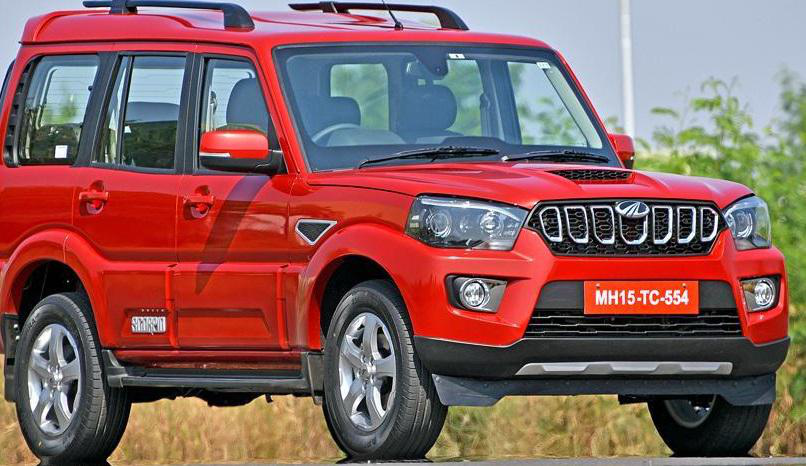

In [255]:
image = df.loc[0, 'image_name']
Image.open(image)

In [256]:
0# function to show image with the bounding box

def show_image_objects(image_row):

  img_path = image_row.image_name

  box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

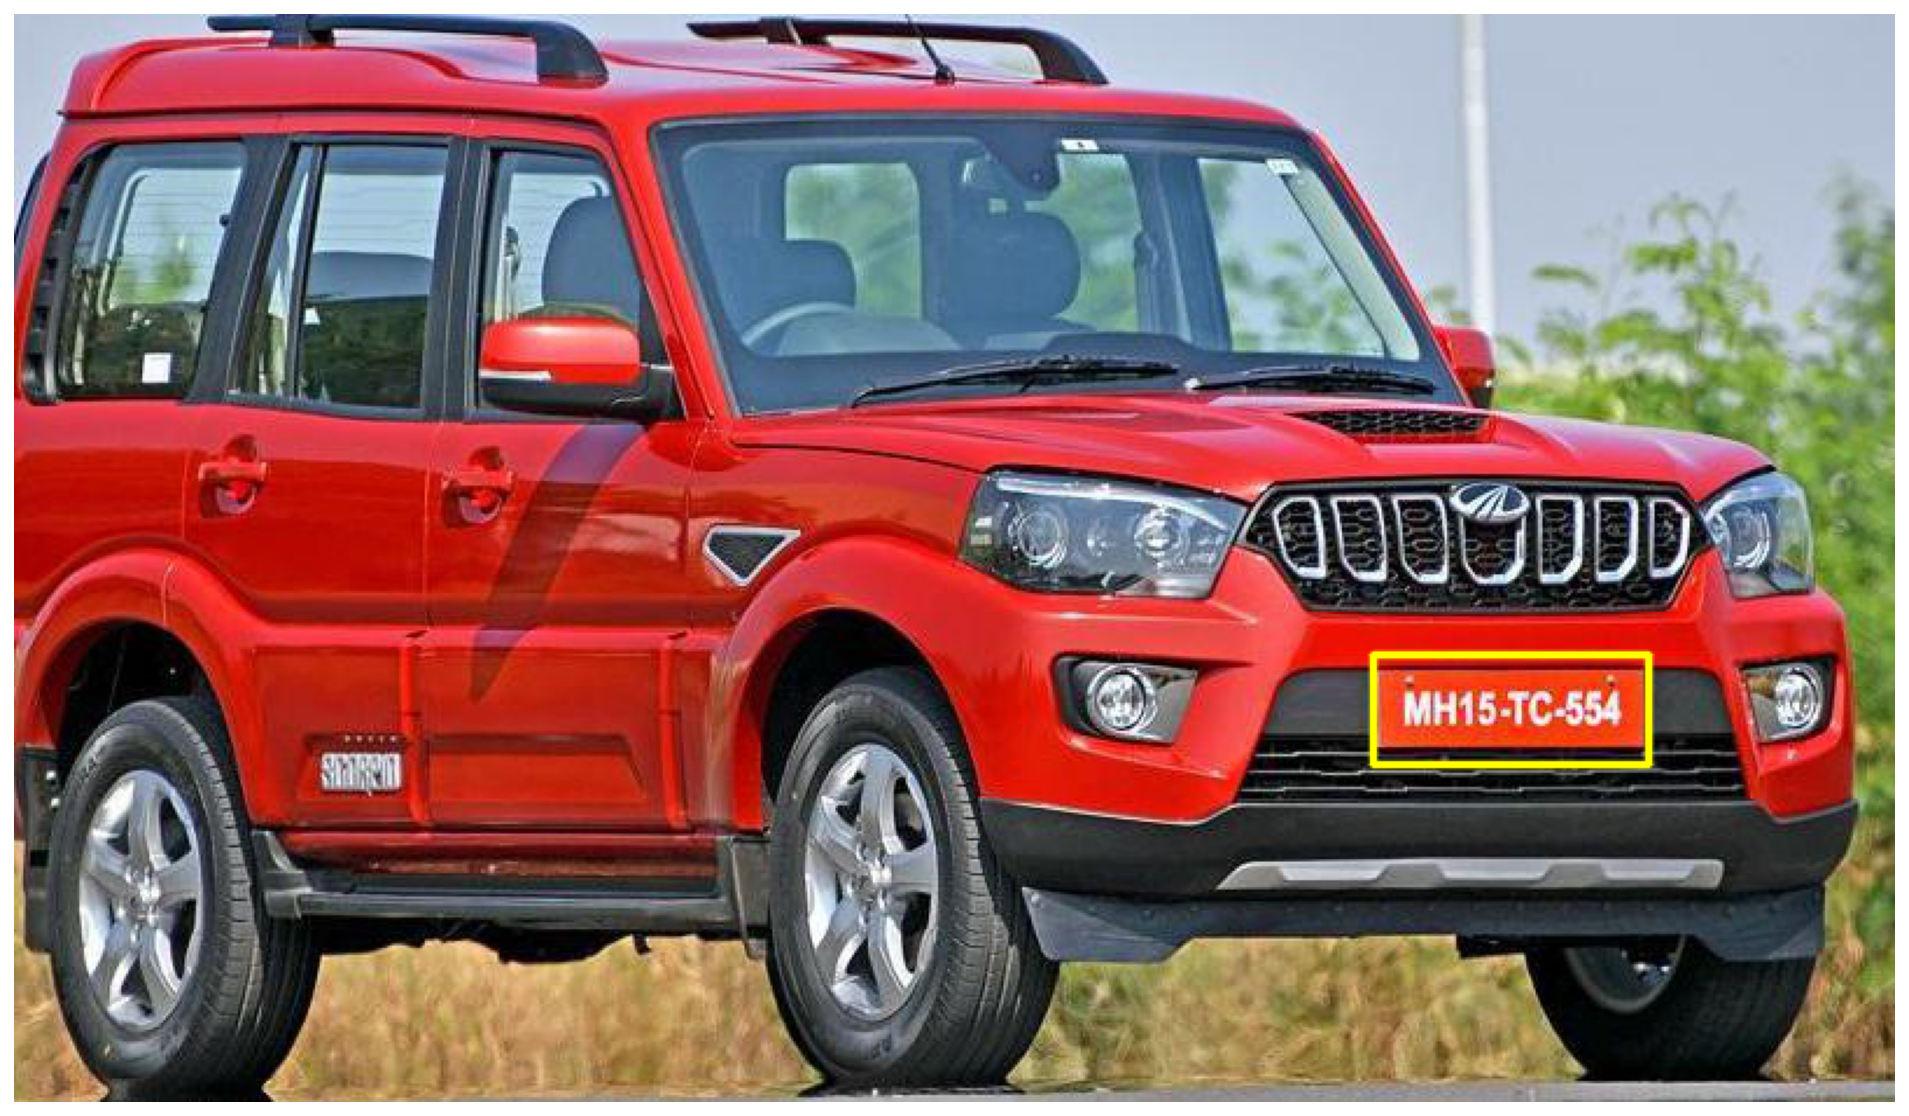

In [257]:
show_image_objects(df.iloc[0])

# Split data

In [258]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [259]:
print(train_df.shape)
print(test_df.shape)

(189, 6)
(48, 6)


In [260]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [261]:
# file with annotation
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [262]:
# define the class
classes = set(['License Plate'])

# write it in the class file
with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [263]:
!head classes.csv

License Plate,0


In [264]:
!head annotations.csv

number_plates/licensed_car_183.jpeg,169,260,358,298,License Plate
number_plates/licensed_car_201.jpeg,251,187,375,234,License Plate
number_plates/licensed_car_230.jpeg,140,149,324,220,License Plate
number_plates/licensed_car_95.jpeg,302,420,671,534,License Plate
number_plates/licensed_car_190.jpeg,115,86,227,117,License Plate
number_plates/licensed_car_84.jpeg,103,209,258,276,License Plate
number_plates/licensed_car_158.jpeg,83,34,369,483,License Plate
number_plates/licensed_car_97.jpeg,123,117,221,170,License Plate
number_plates/licensed_car_147.jpeg,162,227,312,274,License Plate
number_plates/licensed_car_184.jpeg,100,148,259,208,License Plate


In [265]:
cd keras-retinanet/

[Errno 2] No such file or directory: 'keras-retinanet/'
/content/keras-retinanet/keras-retinanet/keras-retinanet


# Training

In [266]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'

urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [ ]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

# Loading the trained model

In [277]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_01.h5  resnet50_csv_10.h5


In [278]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5


# Predictions

In [279]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [280]:
THRES_SCORE = 0.6

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

In [281]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [282]:
test_df.head()

image_name  x_min  ...  y_max     class_name
115  number_plates/licensed_car_115.jpeg     48  ...    188  License Plate
15    number_plates/licensed_car_15.jpeg    274  ...    431  License Plate
211  number_plates/licensed_car_211.jpeg    157  ...    160  License Plate
126  number_plates/licensed_car_126.jpeg    443  ...    347  License Plate
6      number_plates/licensed_car_6.jpeg    227  ...    315  License Plate

[5 rows x 6 columns]

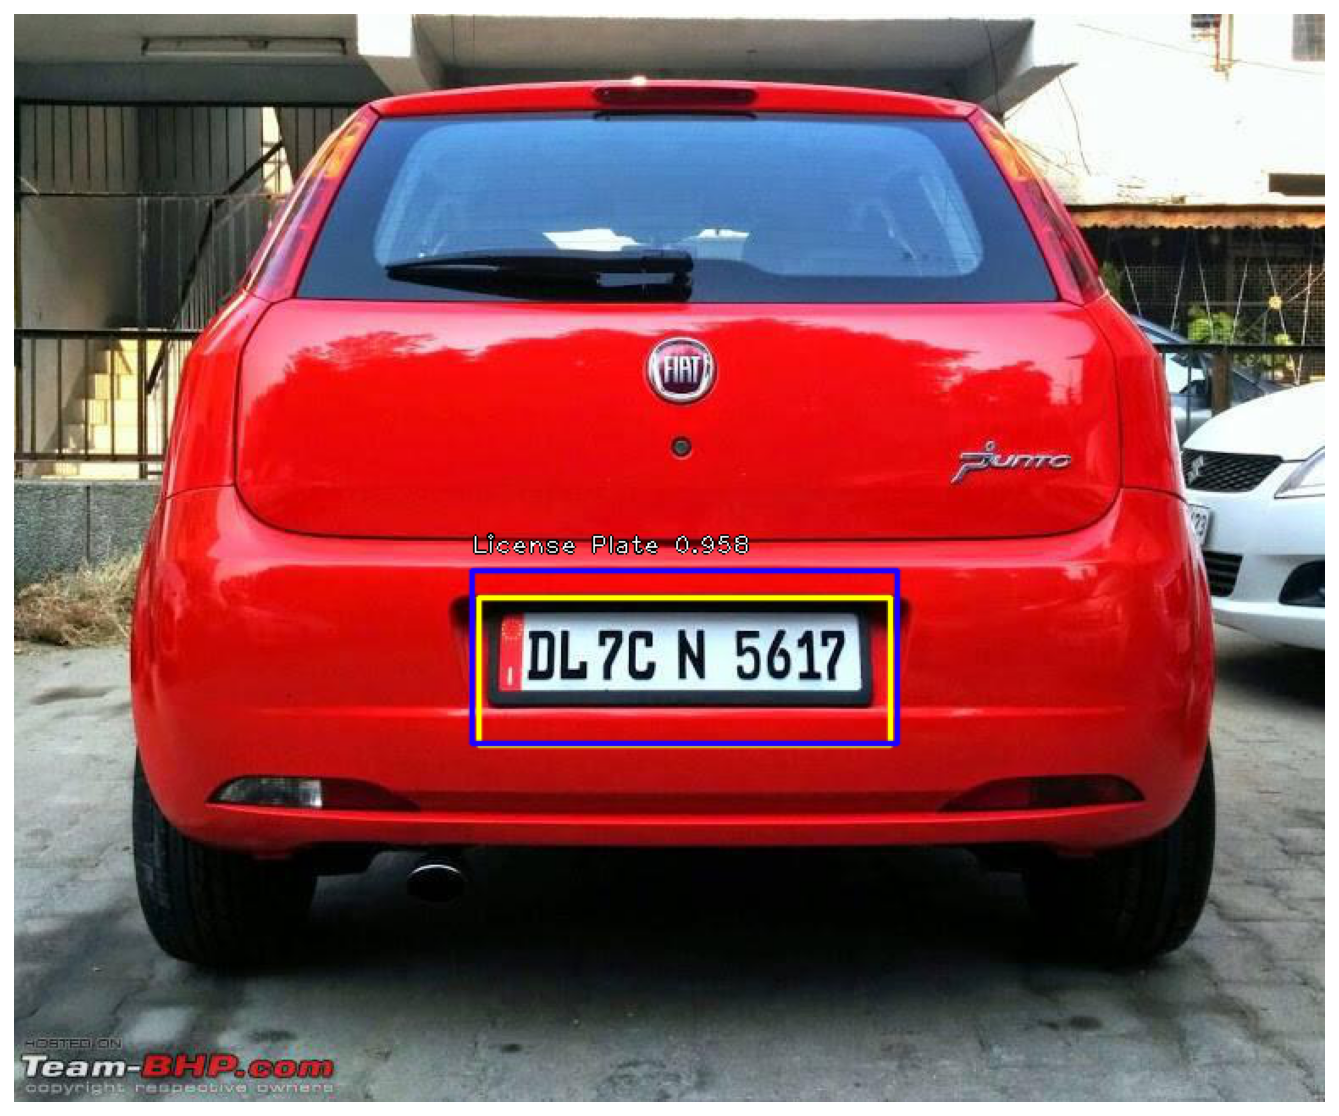

In [283]:
show_detected_objects(test_df.iloc[1])

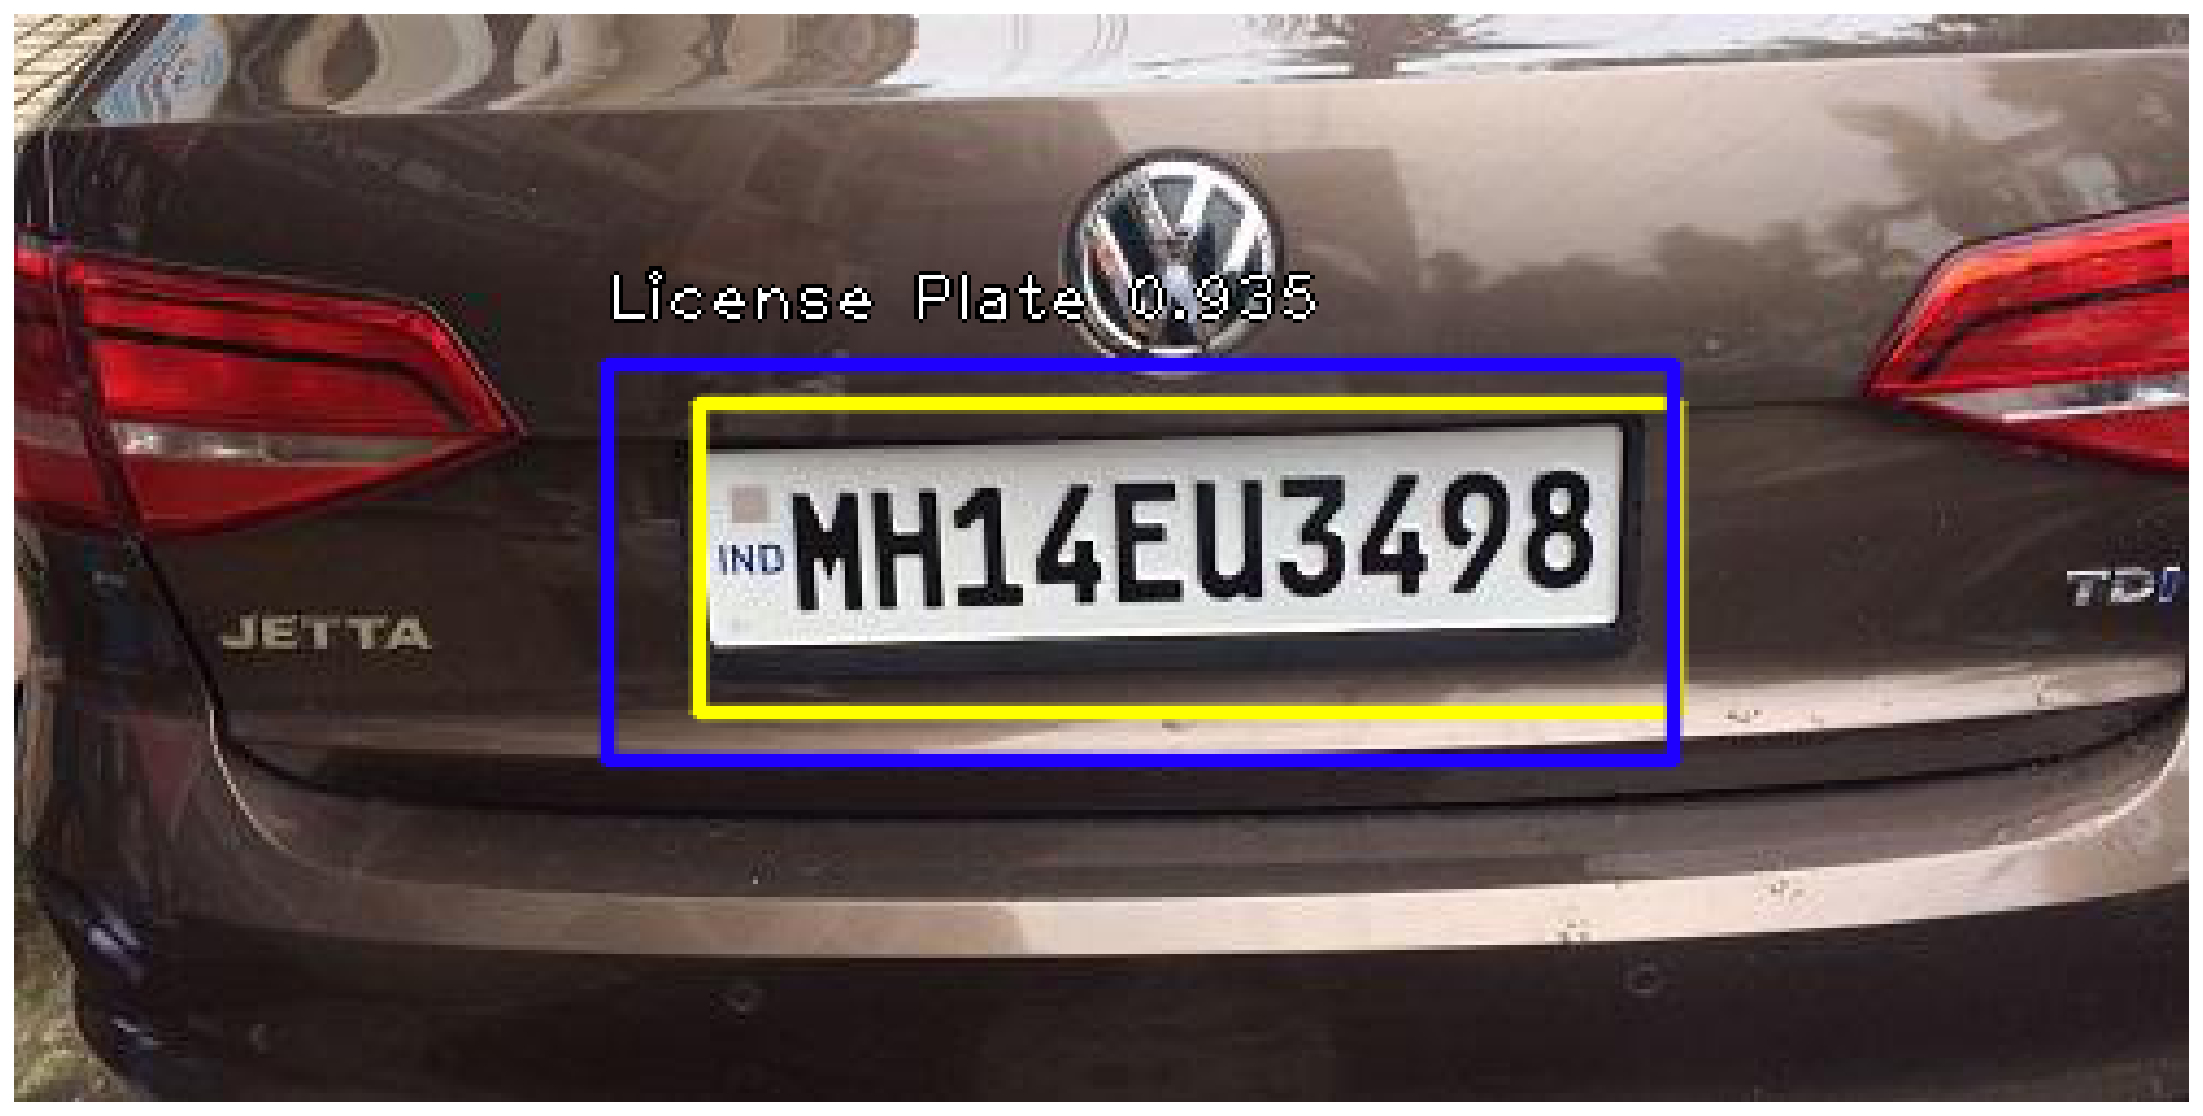

In [284]:
show_detected_objects(test_df.iloc[2])

In [285]:
test_df.head()

image_name  x_min  ...  y_max     class_name
115  number_plates/licensed_car_115.jpeg     48  ...    188  License Plate
15    number_plates/licensed_car_15.jpeg    274  ...    431  License Plate
211  number_plates/licensed_car_211.jpeg    157  ...    160  License Plate
126  number_plates/licensed_car_126.jpeg    443  ...    347  License Plate
6      number_plates/licensed_car_6.jpeg    227  ...    315  License Plate

[5 rows x 6 columns]